In [1]:
# stretching the cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# cuda settings
import os
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.50)

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
mnist = input_data.read_data_sets("../data/mnist")

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


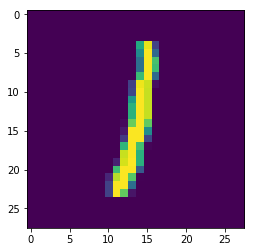

In [5]:
plt.imshow(mnist.train.images[4].reshape(28,28))

In [6]:
# wil take a random noise (z) and return the reconstructed image
def GN(z,reuse=None):
    
    with tf.variable_scope('gen',reuse=reuse):
        layer1 = tf.layers.dense(z,256,activation=tf.nn.relu)
        layer2 = tf.layers.dense(layer1,512,activation=tf.nn.relu)
        output = tf.layers.dense(layer2,784,activation=tf.nn.tanh)

        return output
    

In [7]:
# will take an image x and will predict whether that belongs
# to data sample or random sample
def DN(X,reuse=None):
    
    with tf.variable_scope('dis',reuse=reuse):
        layer1 = tf.layers.dense(X,256,activation=tf.nn.relu)
        layer2 = tf.layers.dense(layer1,128,activation=tf.nn.relu)
        output = tf.layers.dense(layer2,1)

        return output

In [8]:
with tf.name_scope('placeholders'):
    real_image = tf.placeholder(tf.float32,shape=(None,784))
    z = tf.placeholder(tf.float32,shape=(None,100))

In [9]:
with tf.name_scope('logits'):
    fake_image = GN(z)

    real_logit = DN(real_image)
    fake_logit = DN(fake_image,reuse=True)

In [10]:
with tf.name_scope('losses'):
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logit,labels=tf.ones_like(real_logit)*0.9))
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logit,labels=tf.zeros_like(fake_logit)))
    
    dloss = real_loss+fake_loss
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logit,labels=tf.ones_like(fake_logit)*0.9))
    

In [11]:
# alternate loss function as described by ian goodfellow
# dloss = -tf.reduce_mean(tf.log(real_logit_prob)+tf.log(1. - fake_logit_prob))
# gloss = -tf.reduce_mean(tf.log(fake_logit_prob))

In [12]:
with tf.name_scope('varaibles'):
    allvars = tf.trainable_variables()
    dvars = [var for var in allvars if 'dis' in var.name]
    gvars = [var for var in allvars if 'gen' in var.name]

In [13]:
with tf.variable_scope('optimizer',reuse=tf.AUTO_REUSE):
    
    doptimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(dloss,var_list=dvars)
    goptimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(gloss,var_list=gvars)

In [15]:
batch_size = 100
epoch = 100
new_generated_images=[]    

In [16]:
# training
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    # saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    for epoch in range(epoch):
        
        for i in range(mnist.train.num_examples//batch_size):
        # for i in range(1):
            
            batch_data = mnist.train.next_batch(batch_size=batch_size)
            ximage = batch_data[0].reshape((batch_size,784))
            xsample = np.random.uniform(-1.,1.,size=(batch_size,100))
            sess.run(doptimizer,feed_dict={real_image:ximage,z:xsample})
            sess.run(goptimizer,feed_dict={z:xsample})
            if(i%500==0 and epoch%10==0):
                l1 = sess.run(dloss,feed_dict={real_image:ximage,z:xsample})
                l2 = sess.run(gloss,feed_dict={z:xsample})
                print("after {} losses : Descriptor : {} Generator : {}\n".format(i,l1,l2))
        
        print("On epoch {}".format(epoch))
        cur_sample = np.random.uniform(-1,1,size=(1,100))
        gen_sample = sess.run(fake_image,feed_dict={z:cur_sample})
        new_generated_images.append(gen_sample)
    # saver.save(sess,"./gan/mnist_gan_500.ckpt")

after 0 losses : Descriptor : 1.4084502458572388 Generator : 0.6944494843482971

after 500 losses : Descriptor : 0.783744752407074 Generator : 1.5243057012557983

On epoch 0
On epoch 1
On epoch 2
On epoch 3
On epoch 4
On epoch 5
On epoch 6
On epoch 7
On epoch 8
On epoch 9
after 0 losses : Descriptor : 0.5084452033042908 Generator : 2.7426679134368896

after 500 losses : Descriptor : 0.42904311418533325 Generator : 3.156341552734375

On epoch 10
On epoch 11
On epoch 12
On epoch 13
On epoch 14
On epoch 15
On epoch 16
On epoch 17
On epoch 18
On epoch 19
after 0 losses : Descriptor : 0.39062178134918213 Generator : 3.5037548542022705

after 500 losses : Descriptor : 0.43876007199287415 Generator : 3.6465182304382324

On epoch 20
On epoch 21
On epoch 22
On epoch 23
On epoch 24
On epoch 25
On epoch 26
On epoch 27
On epoch 28
On epoch 29
after 0 losses : Descriptor : 0.4584546983242035 Generator : 3.778029203414917

after 500 losses : Descriptor : 0.39610952138900757 Generator : 3.68408632278

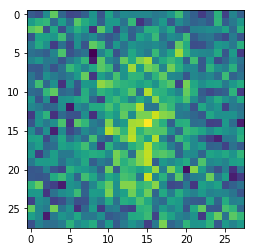

In [23]:
plt.imshow(new_generated_images[1].reshape(28,28))

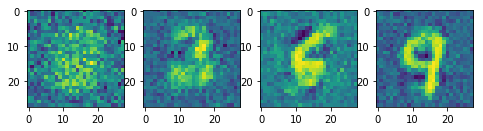

In [38]:
plt.figure(figsize=(8,8))
plt.subplot(1,4,1)
plt.imshow(new_generated_images[2].reshape(28,28))
plt.subplot(1,4,2)
plt.imshow(new_generated_images[20].reshape(28,28))
plt.subplot(1,4,3)
plt.imshow(new_generated_images[62].reshape(28,28))
plt.subplot(1,4,4)
plt.imshow(new_generated_images[80].reshape(28,28))

# previously generated images

In [ ]:
len(generated_images)

In [44]:
# previously generated images conditioned on 1
plt.figure()
plt.subplot(3,3,1)
plt.imshow(generated_images[32].reshape(28,28))
plt.subplot(3,3,2)
plt.imshow(generated_images[83].reshape(28,28))
plt.subplot(3,3,3)
plt.imshow(generated_images[283].reshape(28,28))
plt.subplot(3,3,4)
plt.imshow(generated_images[399].reshape(28,28))
plt.subplot(3,3,5)
plt.imshow(generated_images[400].reshape(28,28))
plt.subplot(3,3,6)
plt.imshow(generated_images[650].reshape(28,28))
plt.subplot(3,3,7)
plt.imshow(generated_images[769].reshape(28,28))
plt.subplot(3,3,8)
plt.imshow(generated_images[888].reshape(28,28))
plt.subplot(3,3,9)
plt.imshow(generated_images[999].reshape(28,28))